## Project Reference Link: https://github.com/akmadan/Emotion_Detection_CNN
## Dataset Link: https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Import Libraries

In [1]:
import tensorflow as tf ##pip install tensorflow-gpu (code to install tensorflow in anaconda cmd)
import cv2 ##pip install opencv-contrib-python (code to install opencv in anaconda cmd)
import os
import matplotlib.pyplot as plt ##pip install matplotlib (code to install matplotlib in anaconda cmd)
import numpy as np ##pip install numpy (code to install numpy in anaconda cmd)
import pandas as pd ##pip install pandas (code to install panda in anaconda cmd)
import seaborn as ans ##pip install seaborn (code to install seaborn in anaconda cmd)

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Try reading and displaying image from dataset

In [2]:
picture_size = 48
folder_path = "DataSet/images/"

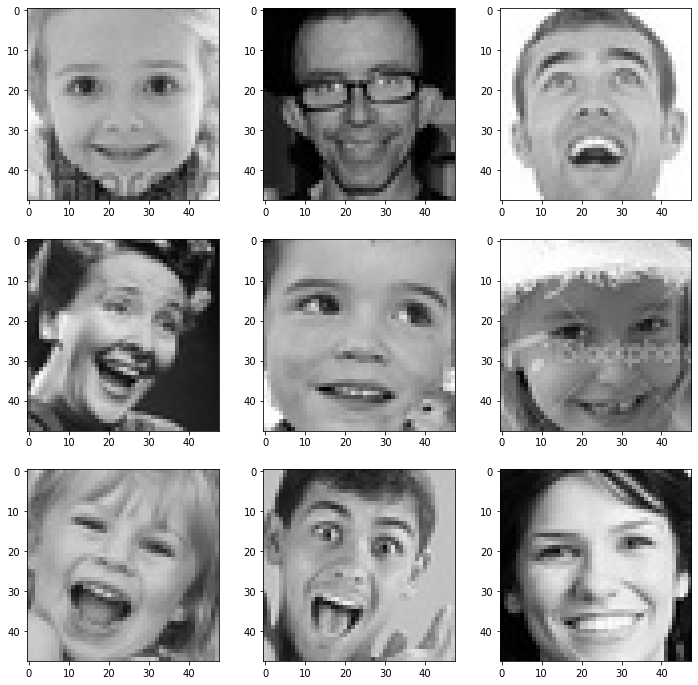

In [3]:
expression = 'happy' ## select expression

plt.figure(figsize= (12,12)) ## set plot figure size
for i in range(1, 10, 1): ## loop and select a range of images
    plt.subplot(3,3,i) ## show the images in a 3 x 3 format
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Training and Validate Data

### Bellow codes will take the images from both train and validate sets and read the images. The images read will have it's size set to 48 x 48. Besides that, the color of the image will be set to greyscale as the image only colors that are shades of gray. Therefore, less information needs to be provided for each pixel. The batch size is also set to 32. This means that the training model will take 32 training example (files) in one iteration. The class mode is also set tp "categorical" as we have 7 emotions categorize in our datasets. In the training set, the data are shuffled as to prevent the deep learning model from learning the sequences of the data. This will allow the deep learning to be more dynamic and robust.

### The dataset was modified from the original dataset and split into a 8:2 ratio (80% training images and 20% test images).

In [4]:
batch_size  = 32 ## how many training example (files) that your model should take in one iteration


datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 18055 images belonging to 6 classes.
Found 3025 images belonging to 6 classes.


# Building the CNN model

## Convolutional Neural Networks (CNNs) is the most popular neural network model being used for image classification problem. The big idea behind CNNs is that a local understanding of an image is good enough. The practical benefit is that having fewer parameters greatly improves the time it takes to learn as well as reduces the amount of data required to train the model. Instead of a fully connected network of weights from each pixel, a CNN has just enough weights to look at a small patch of the image. It’s like reading a book by using a magnifying glass; eventually, you read the whole page, but you look at only a small patch of the page at any given time.

## 4-Conv Layered CNN Model 
Reference Link: https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d#:~:text=Convolutional%20Neural%20Networks%20(CNNs)%20is,an%20image%20is%20good%20enough.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

no_of_classes = 6

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        1

# Set Training Callbacks list by defining Save Checkpoint, Early Stopping and Reduce Learning Rate

In [6]:
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0, 
                               patience=15,
                               verbose=1,
                               restore_best_weights=True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=15,
                                        verbose=1,
                                        min_delta=0.0001
                                       )

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 70

## Compile Model

In [7]:
opt = Adam(learning_rate = 0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['acc'])

## Train Model

In [8]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/70
564/564 [==============================] - 79s 139ms/step - loss: 2.5027 - acc: 0.2365 - val_loss: 1.7213 - val_acc: 0.3208

Epoch 00001: val_acc improved from -inf to 0.32081, saving model to .\model.h5
Epoch 2/70
564/564 [==============================] - 79s 140ms/step - loss: 2.1637 - acc: 0.2725 - val_loss: 1.6359 - val_acc: 0.3567

Epoch 00002: val_acc improved from 0.32081 to 0.35672, saving model to .\model.h5
Epoch 3/70
564/564 [==============================] - 81s 143ms/step - loss: 1.9734 - acc: 0.3119 - val_loss: 1.5710 - val_acc: 0.3820

Epoch 00003: val_acc improved from 0.35672 to 0.38198, saving model to .\model.h5
Epoch 4/70
564/564 [==============================] - 82s 146ms/step - loss: 1.8370 - acc: 0.3369 - val_loss: 1.5214 - val_acc: 0.3856

Epoch 00004: val_acc improved from 0.38198 to 0.38564, saving model to .\model.h5
Epoch 5/70
564/564 [==============================] - 82s 146ms/step - loss: 1.7493 - acc: 0.3563 - val_loss: 1.4367 - val_acc: 0.4


Epoch 00039: val_acc improved from 0.68118 to 0.68152, saving model to .\model.h5
Epoch 40/70
564/564 [==============================] - 81s 144ms/step - loss: 0.8512 - acc: 0.6770 - val_loss: 0.9861 - val_acc: 0.6875

Epoch 00040: val_acc improved from 0.68152 to 0.68750, saving model to .\model.h5
Epoch 41/70
564/564 [==============================] - 82s 145ms/step - loss: 0.8373 - acc: 0.6845 - val_loss: 1.0301 - val_acc: 0.6812

Epoch 00041: val_acc did not improve from 0.68750
Epoch 42/70
564/564 [==============================] - 84s 149ms/step - loss: 0.8216 - acc: 0.6914 - val_loss: 0.9751 - val_acc: 0.6941

Epoch 00042: val_acc improved from 0.68750 to 0.69415, saving model to .\model.h5
Epoch 43/70
564/564 [==============================] - 82s 145ms/step - loss: 0.8016 - acc: 0.6999 - val_loss: 0.9946 - val_acc: 0.6958

Epoch 00043: val_acc improved from 0.69415 to 0.69581, saving model to .\model.h5
Epoch 44/70
564/564 [==============================] - 82s 145ms/step - l

# Plotting Accuracy & Loss

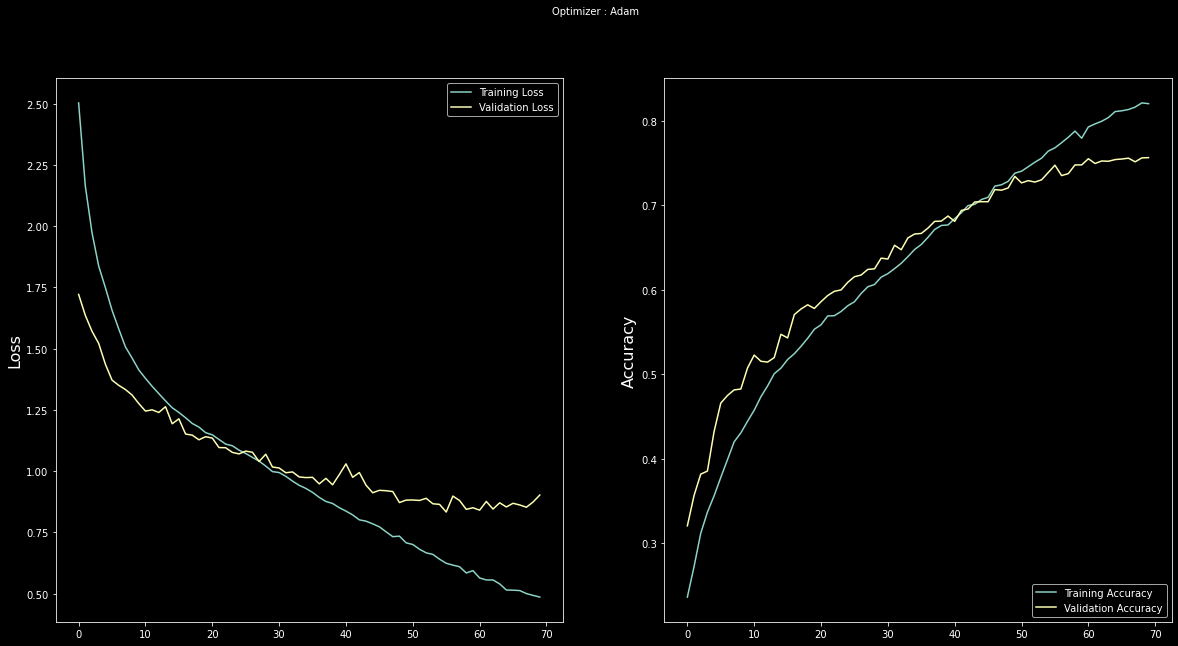

In [9]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Define Function and Test the  Trained Model

In [31]:
from PIL import Image
from tensorflow.keras.models import load_model

def emotionScan(frame):
    modelling = load_model('model.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1: "Fearful", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Surprised"}

    # frame = cv2.imread("image1.jpg")
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),4)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = modelling.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x, y-7), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3, cv2.LINE_AA)

    # cv2_imshow(frame)
    return frame


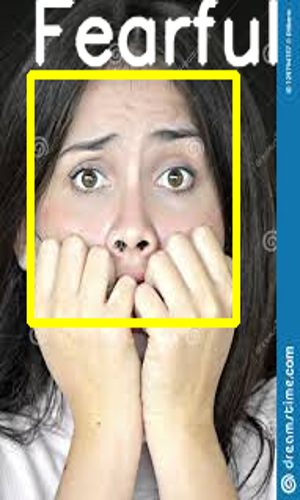

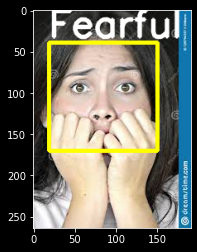

In [38]:
frame = cv2.imread("fear2.jpg")
final = emotionScan(frame)

plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))

# if image to small
recolor = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
img = Image.fromarray(recolor, 'RGB')
img = img.resize((300,500))
display(img)

